In [69]:
# Data imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# # ML imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# read data
df = pd.read_csv("apis/tweet_data.csv")

# sample data
df = df.sample(frac=1).reset_index(drop=True)

# clean tweet text
df['Text'] = df['Text'].apply(lambda x: x.lower())  # transform text to lowercase
df['Text'] = df['Text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
print(df.shape)
df.head(10)

(5791, 2)


,Text,Sentiment
0,ohi setups mnkd dvax anad atm azk bee dang gev...,1
1,the fund will provide financing to companies h...,1
2,mcp i like the company but no,-1
3,india is expected to post sharp turnaround in ...,1
4,swi solarwinds this is houston you have cleare...,1
5,aap dumping into the close still see this goin...,-1
6,user eaders ead bac on which side is the quest...,-1
7,isopropylalcohol prices have more than tripled...,-1
8,a quiet carl icahn bullish nfx shorts should...,1
9,hope you got short aig,-1


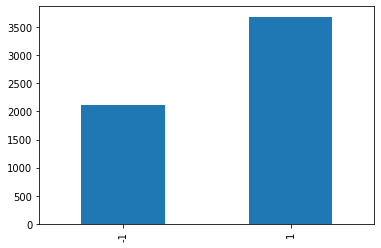

In [4]:
df['Sentiment'].value_counts().sort_index().plot.bar()
plt.savefig("images/single_count.png")

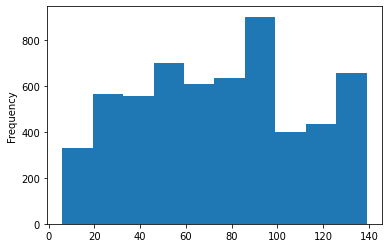

In [6]:
df['Text'].str.len().plot.hist()
plt.savefig("images/tweet_len.png")

In [7]:
# X as tokenize data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['Text'].values)
X = tokenizer.texts_to_sequences(df['Text'].values)
X = pad_sequences(X)
print("X tokenized data = ", X[:5])

X tokenized data =  [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0 4776  771 1379  772  933 2530 3238 4777 4778  598 1553 4779 1554
  3239 3240 2065]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    1  426   18 2531 2532    2  376  217   62    1 2533
    63  284 4780]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  352   15   29    1
   273   32   70]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0  599   10  573    2  263 3241 2534    5 4781  247  370  773
  4782 2066 4783]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0 1123 4784   14   10 4785   41   51 1555    1 3242
  4786    2 1231]]


In [13]:
# Y as buckets of Sentiment column
y = pd.get_dummies(df['Sentiment']).values
[print(df['Sentiment'][i], y[i]) for i in range(0, 5)]

1 [0 1]
1 [0 1]
-1 [1 0]
1 [0 1]
1 [0 1]


[None, None, None, None, None]

In [70]:
# lstm create model
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(GRU(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

In [71]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 31, 256)           1280000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 256)           0         
_________________________________________________________________
gru (GRU)                    (None, 31, 256)           394752    
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               394752    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 2,070,018
Trainable params: 2,070,018
Non-trainable params: 0
_________________________________________________________________


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [73]:
batch_size = 32
epochs = 8

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/8
145/145 - 42s - loss: 0.5823 - accuracy: 0.6921
Epoch 2/8
145/145 - 36s - loss: 0.3641 - accuracy: 0.8469
Epoch 3/8
145/145 - 41s - loss: 0.2293 - accuracy: 0.9063
Epoch 4/8
145/145 - 39s - loss: 0.1341 - accuracy: 0.9495
Epoch 5/8
145/145 - 40s - loss: 0.0926 - accuracy: 0.9637
Epoch 6/8
145/145 - 35s - loss: 0.0594 - accuracy: 0.9778
Epoch 7/8
145/145 - 35s - loss: 0.0480 - accuracy: 0.9838
Epoch 8/8
145/145 - 35s - loss: 0.0373 - accuracy: 0.9870


In [74]:
predictions = model.predict(X_test)

In [75]:
pos_count, neg_count = 0, 0
real_pos, real_neg = 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==1:
        pos_count += 1
    else:
        neg_count += 1
    if np.argmax(y_test[i])==1:    
        real_pos += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Negative predictions:', neg_count)

print('Real neutral:', real_pos)
print('Real negative:', real_neg)

Positive predictions: 719
Negative predictions: 440
Real neutral: 752
Real negative: 407


In [76]:
import matplotlib.pyplot as plt

In [77]:
print(history.history['loss'], )
predictions = [pos_count, neg_count]
real = [real_pos, real_neg]
labels = ['Positive', 'Negative']

[0.5822564959526062, 0.36414289474487305, 0.22926323115825653, 0.1341038942337036, 0.09261605143547058, 0.0593746118247509, 0.048009730875492096, 0.03731507807970047]


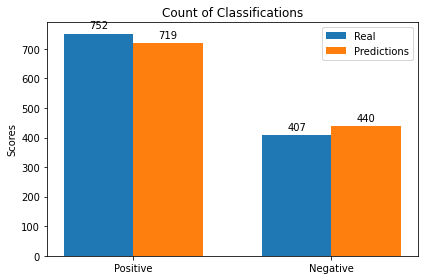

In [78]:
x = np.arange(len(labels))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, real, width, label='Real')
rects2 = ax.bar(x + width/2, predictions, width, label='Predictions')

ax.set_ylabel('Scores')
ax.set_title('Count of Classifications')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.savefig("images/predictions_gru.png")
plt.show()

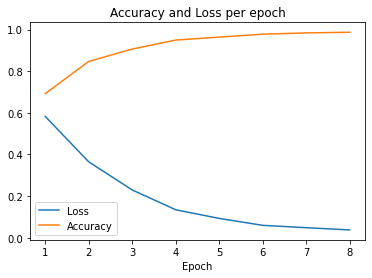

In [79]:
fig, ax = plt.subplots()
loss = history.history['loss']
epoch = [item for item in range(1,9)]
accuracy = history.history['accuracy']
ax.plot(epoch, loss, label = "Loss")
ax.plot(epoch, accuracy, label = "Accuracy")

ax.set_xlabel('Epoch')
ax.set_title('Accuracy and Loss per epoch')
plt.legend()
plt.savefig("images/epoch_gru.png")
plt.show()

In [55]:
import yfinance as yf

stock = yf.Ticker("TSLA")
data = stock.history(period="10d", interval="1d")
close_data = list(data["Close"])

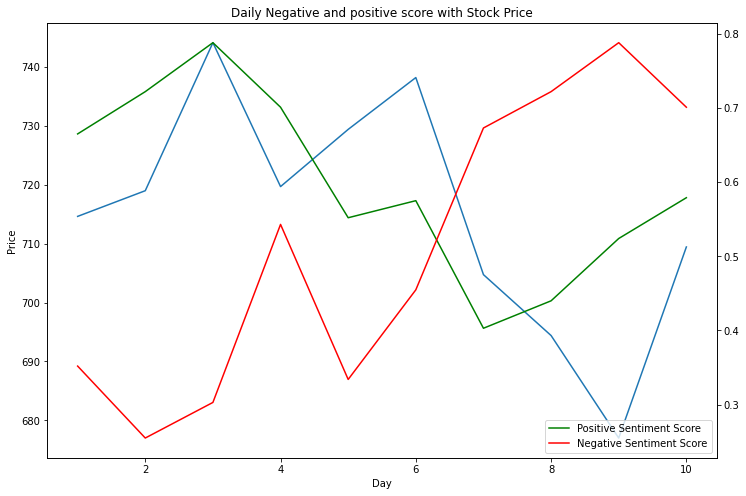

In [80]:
day = [day for day in range(1, 11)]


fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(day, close_data, label="TSLA Price")
positive = [0.665, 0.722, 0.788, 0.701, 0.552, 0.575, 0.403, 0.440, 0.524, 0.579] 
negative = [0.352, 0.255, 0.303, 0.543, 0.334, 0.4548, 0.673, 0.722, 0.788, 0.701]

ax2 = ax.twinx()
ax2.plot(day, positive, label="Positive Sentiment Score", color="g")
ax2.plot(day, negative, label = "Negative Sentiment Score", color="r")

plt.legend()
ax.set_title('Daily Negative and positive score with Stock Price')
ax2.set_xlabel('Sentiment Score')
ax.set_ylabel('Price')
ax.set_xlabel('Day')
plt.savefig("images/main.png")
plt.show()